In [10]:
from detect import run

In [11]:
from pathlib import Path
dest_folder = Path("img")
import os
os.makedirs(dest_folder, exist_ok=True)
res = 1280
grid= 32
weights = "models/yolov5s6_99.pt"

#img_name = "EDDV_09L_35_25.jpeg"
#img_name = "EHAM_18R_35_27.jpeg"
img_name = "KJFK_22L_35_29.jpeg" # trace de pneu ?
#img_name = "DAAS_27_35_30.jpeg" # pas de trace de pneu
#img_path = f"../datasprint/data/LARD_test/LARD_test_synth/images/{img_name}"
img_path = img_name
if img_path != img_name : # uncropped
    cropped = False
else:
    cropped = True
model, img, bbox_img, pred = run(weights=weights, source=img_path, 
                                 data="models/runway.yaml",imgsz=(res,res))

YOLOv5  v7.0-129-gb54fd0a Python-3.8.16 torch-2.0.0+cpu CPU

Fusing layers... 
YOLOv5s6 summary: 206 layers, 12308200 parameters, 0 gradients, 16.1 GFLOPs
image 1/1 C:\Users\maxime.carrere\PycharmProjects\yolov5\KJFK_22L_35_29.jpeg: 1088x1280 1 runway, 725.0ms
Speed: 6.0ms pre-process, 725.0ms inference, 5.0ms NMS per image at shape (1, 3, 1280, 1280)
Results saved to runs\detect\exp96


tensor([[[3.46101e+00, 3.19881e+00, 1.38785e+01, 1.47201e+01, 3.19273e-06, 9.99991e-01],
         [1.07938e+01, 5.24089e+00, 2.26971e+01, 9.87955e+00, 3.81465e-07, 9.99993e-01],
         [1.95316e+01, 5.40862e+00, 2.61809e+01, 8.24963e+00, 1.13578e-06, 9.99992e-01],
         ...,
         [1.12714e+03, 1.01717e+03, 3.92282e+02, 2.47132e+02, 1.28579e-04, 9.99974e-01],
         [1.16968e+03, 1.01983e+03, 3.70723e+02, 2.94312e+02, 4.63890e-05, 9.99972e-01],
         [1.22129e+03, 1.02380e+03, 4.57565e+02, 3.60018e+02, 1.72826e-05, 9.99972e-01]]])
min tensor(0.99973)
sup values tensor([[7.26296e+02, 6.00733e+02, 8.93711e+02, 3.44987e+02, 5.71872e-01, 9.99981e-01],
        [7.26924e+02, 6.02318e+02, 8.81397e+02, 3.31741e+02, 5.51659e-01, 9.99977e-01],
        [7.28985e+02, 6.05360e+02, 8.41795e+02, 3.18784e+02, 5.02825e-01, 9.99980e-01],
        [7.30626e+02, 6.02495e+02, 8.30491e+02, 3.06380e+02, 5.50078e-01, 9.99983e-01]])
[tensor([[2.79440e+02, 4.28240e+02, 1.17315e+03, 7.73226e+02, 5.71

In [12]:
from pytorch_yolo_wrapper import TemplateTorchWrapper

In [13]:
from xplique.attributions.object_detector import BoundingBoxesExplainer
from xplique.attributions import SobolAttributionMethod
import numpy as np
import tensorflow as tf
from xplique.attributions import Lime
from xplique.attributions import Ri

def wrap_and_run_sobol(model, preds, img):
    wrapper = TemplateTorchWrapper(model)
    blackbox_explainer = SobolAttributionMethod(wrapper, batch_size=32, grid_size=grid)
    explainer_wrapper = BoundingBoxesExplainer(blackbox_explainer)
    return explainer_wrapper.explain(np.array(img).transpose(0,2,3,1), wrapper.get_xplique_bboxes(preds))

def wrap_and_run_lime(model, preds, img):
    wrapper = TemplateTorchWrapper(model)
    # blackbox_explainer = SobolAttributionMethod(wrapper, batch_size=32)
    blackbox_explainer = Lime(wrapper)  # , map_to_interpret_space=custom_map)
    # explanations = blackbox_explainer.explain(images, labels)
    explainer_wrapper = BoundingBoxesExplainer(blackbox_explainer)
    return explainer_wrapper.explain(np.array(img).transpose(0,2,3,1), wrapper.get_xplique_bboxes(preds))

def wrap_and_run_sobol(model, preds, img):
    wrapper = TemplateTorchWrapper(model)
    blackbox_explainer = SobolAttributionMethod(wrapper, batch_size=32, grid_size=grid)
    explainer_wrapper = BoundingBoxesExplainer(blackbox_explainer)
    return explainer_wrapper.explain(np.array(img).transpose(0,2,3,1), wrapper.get_xplique_bboxes(preds))

In [18]:
method = "lime"
if method == "sobol":
    explanation = wrap_and_run_sobol(model, pred, img)
else:
    explanation = wrap_and_run_lime(model,pred, img)

C:\Users\maxime.carrere\Miniconda3\envs\yolov5\lib\site-packages\xplique\plots\image.py:30: RuntimeWarning: invalid value encountered in divide
  image /= image.max()


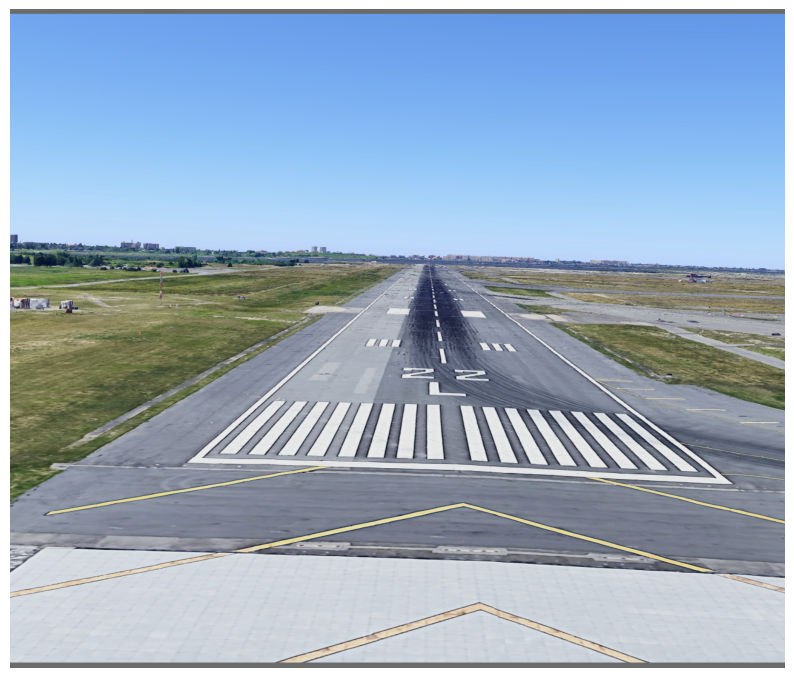

In [19]:
from xplique.plots import plot_attributions
from xplique.plots.image import _normalize, _clip_percentile
import matplotlib.pyplot as plt
%matplotlib inline
#image np.swapaxes(img,1,-1)[0] #
image = np.array(img).transpose(0,2,3,1)[0]
expl = explanation[0] 
#expl = np.swapaxes(explanation[0], 0,1)
cmap = "jet"
alpha = 0.5
absolute_value= False
clip_percentile = False
plt.figure(figsize=(10,10))
if image is not None:
    image = _normalize(image)
    plt.imshow(image)

if explanation.shape[-1] == 3:
    expl= np.mean(expl, -1)

if absolute_value:
    expl = np.abs(expl)

if clip_percentile:
    expl = _clip_percentile(expl, clip_percentile)

expl = _normalize(expl)

plt.imshow(expl, cmap=cmap, alpha=alpha)
plt.axis('off')
plt.savefig(dest_folder / f"yolov5_{method}_corrected_cropped_{cropped}_alpha_{alpha}_{res}_grid_{grid}_{img_name[:-5]}.png")

In [20]:
np.savez(dest_folder / f"yolov5_{method}_corrected_bbox_cropped_{cropped}_alpha_{alpha}_{res}_grid_{grid}_{img_name[:-5]}_explanation.npz",explanation)

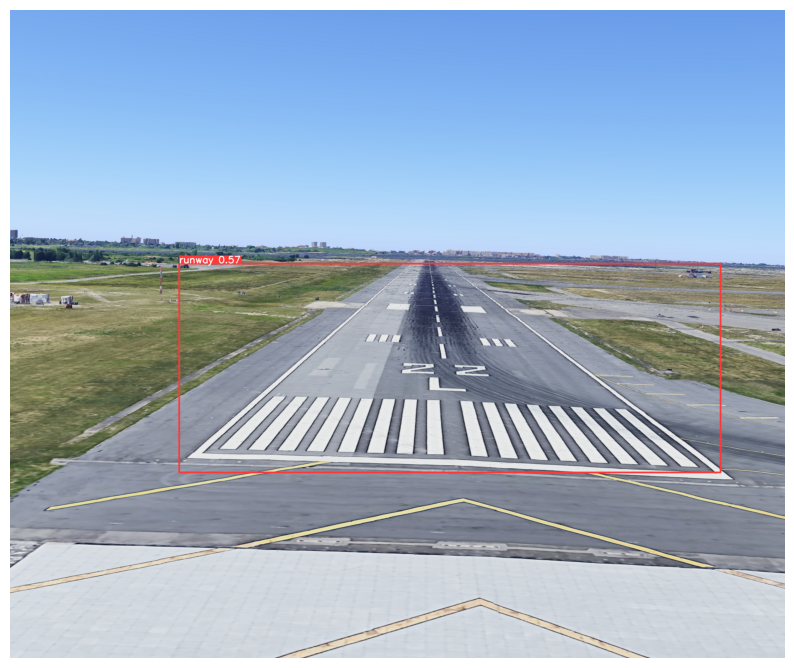

In [21]:
from xplique.plots import plot_attributions
from xplique.plots.image import _normalize, _clip_percentile
import matplotlib.pyplot as plt
import cv2

%matplotlib inline
#image np.swapaxes(img,1,-1)[0] #
image = bbox_img[:,:,::-1]
expl = explanation[0]
size = bbox_img.shape
expl = cv2.resize(np.array(expl), (size[1], size[0]), interpolation=cv2.INTER_CUBIC)
#expl = np.swapaxes(explanation[0], 0,1)
cmap = "jet"
alpha = 0.4
absolute_value= False
clip_percentile = False
plt.figure(figsize=(10,10))
if image is not None:
    image = _normalize(image)
    plt.imshow(image)

if explanation.shape[-1] == 3:
    expl= np.mean(expl, -1)

if absolute_value:
    expl = np.abs(expl)

if clip_percentile:
    expl = _clip_percentile(expl, clip_percentile)

expl = _normalize(expl)

plt.imshow(expl, cmap=cmap, alpha=alpha)
plt.axis('off')
plt.savefig(dest_folder / f"yolov5_{method}_bbox_full_cropped_{cropped}_alpha_{alpha}_{res}_grid_{grid}_{img_name[:-5]}.png")

In [36]:
from sklearn import linear_model
from itertools import product
def explore_lime(model, preds, img):
    wrapper = TemplateTorchWrapper(model)
    common_parameters = {
        "model": wrapper,
        "batch_size": 32,
        "map_to_interpret_space": None,  # default function
        "nb_samples": 4000,
        "ref_value": None,  # default value
    }

    # Lime specific parameters
    interpretable_model = linear_model.Ridge(alpha=2)  # default function
    pertub_func = None  # default function
    prob = 0.5  # default value

    # Possible similarity settings
    distance_modes = ["euclidean", "cosine"]
    kernel_widths = [10.0, 45.0, 1000.0]
    similarity_kernel_parameters = []
    for distance_mode, kernel_width in product(distance_modes, kernel_widths):
        similarity_kernel_parameters.append({
            "similarity_kernel": None,  # default function
            "distance_mode": distance_mode,
            "kernel_width": kernel_width,
        })
    expls = []
    for similarity_kernel_params in similarity_kernel_parameters:
        explainer = BoundingBoxesExplainer(Lime(**common_parameters,
                         **similarity_kernel_params,
                         interpretable_model = interpretable_model,
                         pertub_func = pertub_func,
                         prob = prob))

        try:
            explanation = explainer.explain(np.array(img).transpose(0,2,3,1), wrapper.get_xplique_bboxes(preds))
            expls.append(explanation)
        
            plot_attributions(explanation, np.array(img).transpose(0,2,3,1), img_size=5, cmap='cividis', alpha=0.6)
            plt.show()
        except ZeroDivisionError:
            print("Zero div error for ",str(similarity_kernel_params["similarity_kernel"]))
    return expls

Zero div error for  None


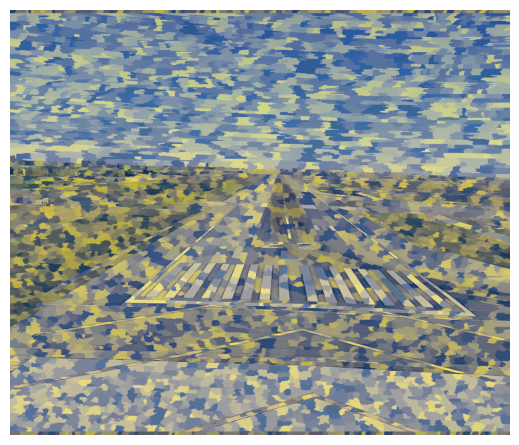

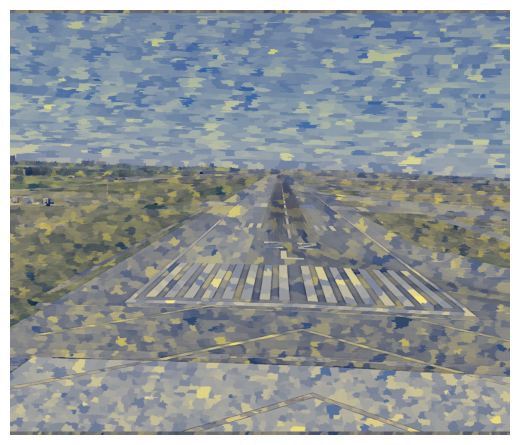

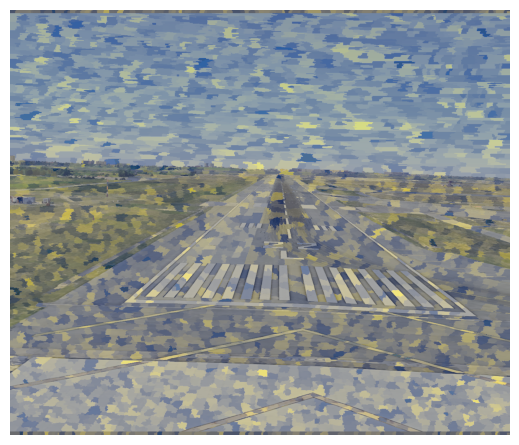

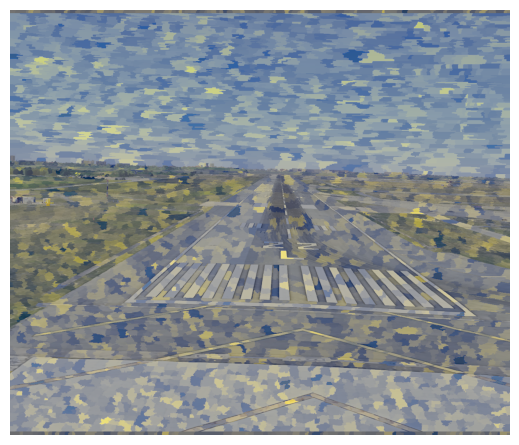

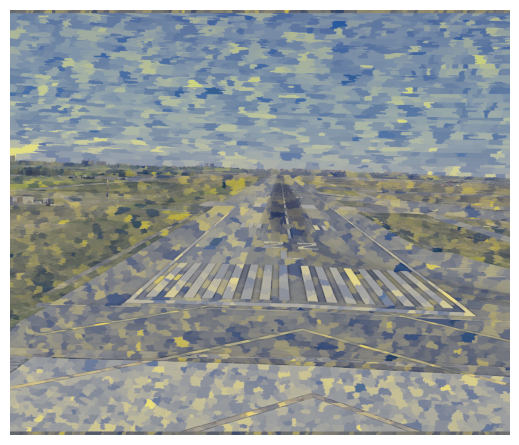

In [37]:
expls = explore_lime(model,pred, img)